In [1]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `c:\Users\Andreas\Dropbox\phd\Image analysis\ColonyImages`


In [ ]:
Threads.nthreads()

10

In [ ]:
using Revise, CairoMakie
using ColonyImages
using DataFrames, CSV, FileIO, Dates, Serialization
import ColorSchemes as co 

In [16]:
df = DataFrame(data_set =String[], colony = String[], time = Int[], 
    metric_OG =Vector{Vector{Int64}}(undef,0), metric_cov = Vector{Vector{Int64}}(undef,0),
    pair_OG =Vector{Vector{Int64}}(undef,0),pair_cov =Vector{Vector{Int64}}(undef,0),
    OG_size = Int[], border_points =Vector{Vector{CartesianIndex{2}}}(undef,0), Parameters = Vector{parameters}(undef,0) )

Row,data_set,colony,time,metric_OG,metric_cov,pair_OG,pair_cov,OG_size,border_points,Parameters
,String,String,Int64,Array…,Array…,Array…,Array…,Int64,Array…,paramete…


In [17]:
para = parameters(
        im_size = [1600,1600],
        time_points = [0:4:48...],
        colony_nr = 8);

simulations = ["Random", "Finger_weak", "Finger_strong"]
#simulations = ["Random"]
Points= lattice_points(Int(maximum(para.im_size)÷2))
plot_sim = false

false

In [18]:
name_of_sim = "$(para.colony_nr)_col_$(length(simulations))_testikus"
fig_path = joinpath("data", "artificial",name_of_sim)
path_metric = joinpath("data", "metrics")
mkpath(path_metric)
mkpath(fig_path)

"data\\artificial\\8_col_3_testikus"

## Create empty datastructure for colony images

In [19]:
pixel_to_add_vec = Int[];
vec_of_sims = Vector{Vector{BitArray{3}}}(undef, 0)
for i in 1:length(simulations)
    img_int_vec_1 = Vector{BitArray{3}}(undef, 0)
    for i in 1:para.colony_nr
        hans =BitArray(zeros(Bool, para.im_size...,para.stacks))
        push!(img_int_vec_1, hans)
    end
    push!(vec_of_sims, img_int_vec_1)
end

In [20]:
copy_int_img = BitArray(zeros(Bool, para.im_size...,))
build_artifical_colony!(para.Center,copy_int_img,para.radius_colony,Points)
pixel_to_add_vec = para.pixel_to_add(copy_int_img);

In [21]:
for (x,sim) in collect(enumerate(simulations))
    Threads.@threads for (i,colony) in collect(enumerate(vec_of_sims[x]))
        for (j,t) in enumerate(para.time_points)
            # use view to work on array directly 
            int_img  = @view colony[:,:,j]
            dir_vec = generate_dir_vec(para)
            if j == 1
                build_artifical_colony!(para.Center,int_img,para.radius_colony,Points)
                #pixel_to_add_vec = para.pixel_to_add(int_img)
            else
                # for unkown reason views require [:] to make assignments 
                int_img[:] = colony[:,:,j-1]
                if sim == "Random"
                    expand_colony_radom_cov!(int_img,pixel_to_add_vec[j-1])
                elseif sim == "Finger_weak"
                    expand_colony_finger_radom_cov!(int_img,pixel_to_add_vec[j-1],dir_vec, still_spawn_rate= para.spawn_rate)
                elseif sim == "Finger_strong"
                    expand_colony_finger_radom_cov!(int_img,pixel_to_add_vec[j-1],dir_vec, still_spawn_rate= 0.0, dir_match_rate = 0.9995)
                end
            end
        end
    end   
end

### Plot first colony test wise to see if everything worked as intended

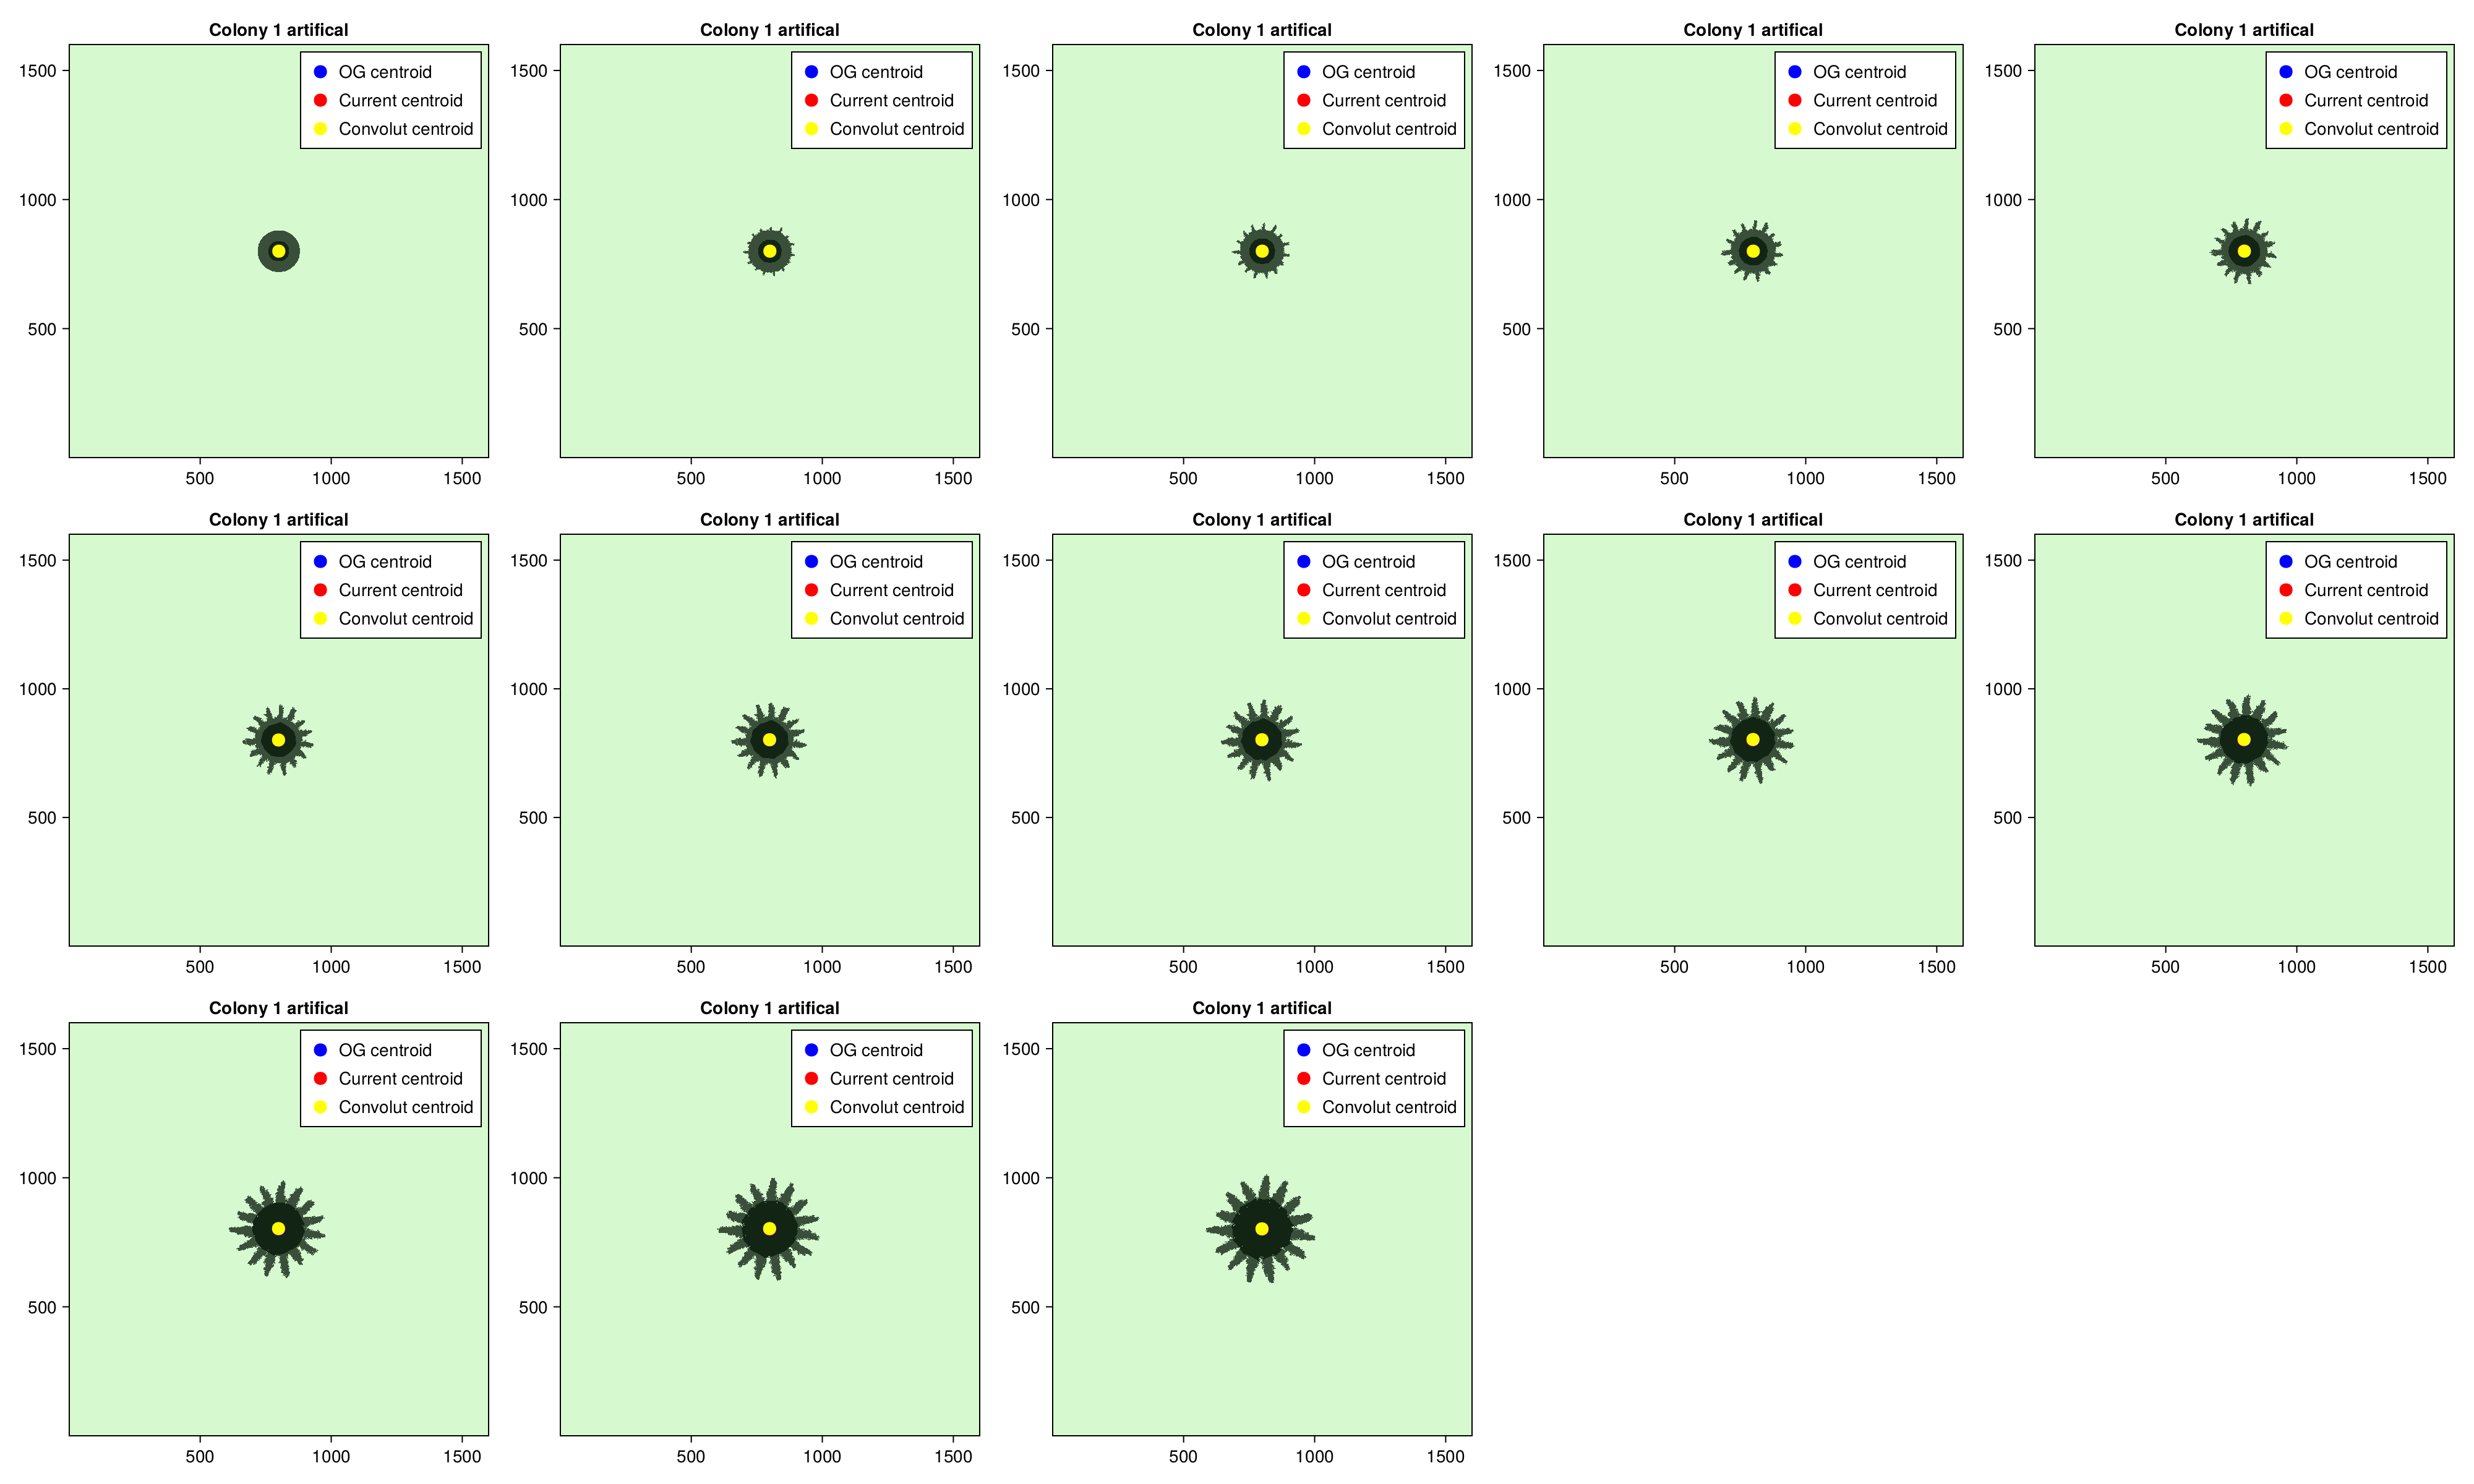

In [10]:
fig_test = plot_time_series_cov_centroid(vec_of_sims[2][1:1], para)

###  Either plot sim into artifical data folder or not to save computation time

In [22]:
if plot_sim 
    for (i,name) in collect(enumerate(simulations))
        fig, data_set_name = plot_and_save_time_series_metrics!(vec_of_sims[i], para,df,Points, name_data = name)
        save(joinpath(fig_path, data_set_name)*".png", fig)
    end
else
    for (i,name) in collect(enumerate(simulations))
        data_set_name = save_time_series_metrics!(vec_of_sims[i], para,df,Points, name_data = name)
    end
end

In [23]:
first(df,2)

Row,data_set,colony,time,metric_OG,metric_cov,pair_OG,pair_cov,OG_size,border_points,Parameters
,String,String,Int64,Array…,Array…,Array…,Array…,Int64,Array…,paramete…
1,Random 2024_04_16,Colony 1 artifical,0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0 … 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]","[63, 46, 59, 53, 58, 57, 57, 58, 56, 62 … 53, 62, 56, 58, 57, 57, 58, 53, 59, 63]","[5582, 5399, 5439, 5603, 5648, 5470, 5497, 5682, 5586, 5495 … 5423, 5611, 5487, 5610, 5572, 5474, 5622, 5610, 5583, 5488]","[5453, 5457, 5523, 5610, 5658, 5649, 5497, 5538, 5565, 5522 … 5571, 5616, 5615, 5590, 5436, 5595, 5558, 5569, 5545, 5528]",20589,"CartesianIndex{2}[CartesianIndex(788, 720), CartesianIndex(789, 720), CartesianIndex(790, 720), CartesianIndex(791, 720), CartesianIndex(792, 720), CartesianIndex(793, 720), CartesianIndex(794, 720), CartesianIndex(795, 720), CartesianIndex(796, 720), CartesianIndex(797, 720) … CartesianIndex(803, 880), CartesianIndex(804, 880), CartesianIndex(805, 880), CartesianIndex(806, 880), CartesianIndex(807, 880), CartesianIndex(808, 880), CartesianIndex(809, 880), CartesianIndex(810, 880), CartesianIndex(811, 880), CartesianIndex(812, 880)]","parameters([0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24.0, 28.0, 32.0, 36.0, 40.0, 44.0, 48.0], 0.8, 0.8, 0.4, 360, 2000000, 300, [1600, 1600], 13, 80, [800, 800], 0.029717, #5, 0.01, [0 1 0; 1 -4 1; 0 1 0], 8, [""Colony 1 artifical"", ""Colony 2 artifical"", ""Colony 3 artifical"", ""Colony 4 artifical"", ""Colony 5 artifical"", ""Colony 6 artifical"", ""Colony 7 artifical"", ""Colony 8 artifical""], 2.0, [0.0, 0.124272, 0.263988, 0.421067, 0.597667, 0.796213, 1.01943, 1.27039, 1.55254, 1.86975, 2.22638, 2.62733, 3.07811], [0.124272, 0.139716, 0.157079, 0.176599, 0.198546, 0.22322, 0.25096, 0.282147, 0.31721, 0.356631, 0.40095, 0.450777], 15, 0.1, #7, 0.2, 0.995, 0.995)"
2,Random 2024_04_16,Colony 1 artifical,4,"[13, 14, 6, 4, 3, 3, 8, 6, 5, 4 … 7, 5, 5, 3, 6, 4, 5, 11, 7, 13]","[7, 6, 2, 5, 2, 2, 1, 1, 2, 0 … 2, 1, 2, 2, 1, 1, 0, 4, 3, 7]","[5218, 6531, 6029, 5515, 5959, 5863, 5695, 5240, 5703, 5874 … 5734, 5776, 5217, 5676, 5672, 5619, 5254, 5814, 6182, 5390]","[5729, 8114, 7233, 5725, 6085, 6283, 5679, 5151, 5422, 5361 … 5449, 5231, 5111, 5637, 5960, 5626, 5292, 6317, 6832, 5829]",20589,"CartesianIndex{2}[CartesianIndex(802, 710), CartesianIndex(801, 711), CartesianIndex(803, 711), CartesianIndex(797, 712), CartesianIndex(800, 712), CartesianIndex(801, 712), CartesianIndex(802, 712), CartesianIndex(796, 713), CartesianIndex(797, 713), CartesianIndex(798, 713) … CartesianIndex(817, 887), CartesianIndex(818, 887), CartesianIndex(819, 887), CartesianIndex(821, 887), CartesianIndex(800, 888), CartesianIndex(801, 888), CartesianIndex(820, 888), CartesianIndex(821, 888), CartesianIndex(821, 889), CartesianIndex(821, 890)]","parameters([0.0, 4.0, 8.0, 12.0, 16.0, 20.0, 24.0, 28.0, 32.0, 36.0, 40.0, 44.0, 48.0], 0.8, 0.8, 0.4, 360, 2000000, 300, [1600, 1600], 13, 80, [800, 800], 0.029717, #5, 0.01, [0 1 0; 1 -4 1; 0 1 0], 8, [""Colony 1 artifical"", ""Colony 2 artifical"", ""Colony 3 artifical"", ""Colony 4 artifical"", ""Colony 5 artifical"", ""Colony 6 artifical"", ""Colony 7 artifical"", ""Colony 8 artifical""], 2.0, [0.0, 0.124272, 0.263988, 0.421067, 0.597667, 0.796213, 1.01943, 1.27039, 1.55254, 1.86975, 2.22638, 2.62733, 3.07811], [0.124272, 0.139716, 0.157079, 0.176599, 0.198546, 0.22322, 0.25096, 0.282147, 0.31721, 0.356631, 0.40095, 0.450777], 15, 0.1, #7, 0.2, 0.995, 0.995)"


In [14]:
serialize(joinpath(path_metric,"$(name_of_sim*Dates.format(now(), "yyyy_mm_dd")).jls"),df)
CSV.write(joinpath(path_metric,"$(name_of_sim*Dates.format(now(), "yyyy_mm_dd")).csv"),df)

"data\\metrics\\8_col_3_testikus2024_04_12.csv"